# **Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs**

## Problem Tasks: 

- Assess if **demographic data** (age group) has _direct and significant impacts_ on **public transport usage**. 

The dataset includes the _**total number of specified transportations to work by age** in ten-year groups_ in New South Wales taken from [the TableBuilder of the Australian Bureau of Statistics (ABS)](https://guest.censusdata.abs.gov.au/webapi/jsf/login.xhtml). 

**The census of Australian** was conducted in 2016, and the dataset was created and filtered from the census surveys of persons in usual residence areas across New South Wales, Australia. 

**Process:**
- Data preparation: 
    - Clean the dataset (transpose column to row, remove logo, title of organisation, etc.). 
    - Group the records into two major groups: under 60 (youth + workforce) years as class 0, over 60 (retiree) years as class 1.
- Data exploration: Plot graphs to compare transport usage of each broader age group to point out any direct relationshop between 2 factors.
- Model training: Logistic Regression, KNN, GaussianNB, and MLPClassifier.

**Goal:**
To study if **any of the predefined transport modes** could _predict a specific age group_, or whether _the working force choose train_ as the most convenient method of transport.

## Import Libraries

In [18]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Functions used for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Import Data and Remove Texts 

As the dataset was taken **from the TableBuilder of the ABS**, we have to add modifications and convert it into an "_analysable_" format in the Notebook environment.

In [2]:
# Import data, skip the rows of logo and titles/names of the organisations
df = pd.read_excel("data/transportmodevsAge.xlsx", skiprows= 8, index_col =0, engine="openpyxl")

# Set the first row as column names
df.columns = df.iloc[0]

# Remove the first two rows after setting it as column names (second row of NaN values and an header description)
df = df.iloc[2:]

# Remove several last rows of copyright, logo and sources
df = df[:5]

# Transpose columns and rows
df = df.T

# Remove several last rows of NaN values
age_total = df[12:13] # the index "Total"
df_age = df[:12] # not include index "Total"

# Rename columns
age_total.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]
df_age.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]

# Remove first row (transport title and NaN value)
df_age = df_age.iloc[1:]

# Final dataframe
df_age


,Train,Bus,Ferry,Tram,Total
AGE10P - Age in Ten Year Groups,,,,,
0-9 years,0,0,0,0,0
10-19 years,10869,8421,69,74,19431
20-29 years,115402,41592,1702,914,159610
30-39 years,114937,40941,3094,1077,160044
40-49 years,69864,28815,2617,722,102016
50-59 years,48007,19717,1522,452,69695
60-69 years,17732,7824,543,159,26257
70-79 years,1781,973,88,13,2855
80-89 years,166,92,4,0,265


### Removing Outliers

The statistics of the _0-9 and 100 years and over_ range are 0; therefore, we consider them as **outliers** and remove them from the dataframe. 

In [3]:
# Exclude outliers 
df_age = df_age[1:10]

### Replace the Total Column

Since there are several incorrect values in the "Total" field, we will re-calculate this field.

In [4]:
# Drop the Total column 
df_age.drop(["Total"], axis=1, inplace=True)

# Create new Total column
df_age["Total"] = df_age.Train + df_age.Bus + df_age.Ferry + df_age.Tram

# Preview new dataframe
df_age

,Train,Bus,Ferry,Tram,Total
AGE10P - Age in Ten Year Groups,,,,,
10-19 years,10869,8421,69,74,19433
20-29 years,115402,41592,1702,914,159610
30-39 years,114937,40941,3094,1077,160049
40-49 years,69864,28815,2617,722,102018
50-59 years,48007,19717,1522,452,69698
60-69 years,17732,7824,543,159,26258
70-79 years,1781,973,88,13,2855
80-89 years,166,92,4,0,262
90-99 years,20,13,0,0,33


### Group Age Ranges into Class

We divide all **11 age ranges** into _two classes of 0 and 1_:
- class 0: the youth and working force 
- class 1: the retiree group.

In [5]:
# Define function to classify age groups
def classify_age_group(age_group):
    youth_working_force = ["10-19 years", "20-29 years", "30-39 years", "40-49 years", "50-59 years"]
    return 0 if age_group in youth_working_force else 1

# Apply function to create Class column dynamically
df_age["Class"] = df_age.index.map(classify_age_group)

# Preview new dataframe
df_age

,Train,Bus,Ferry,Tram,Total,Class
AGE10P - Age in Ten Year Groups,,,,,,
10-19 years,10869,8421,69,74,19433,0
20-29 years,115402,41592,1702,914,159610,0
30-39 years,114937,40941,3094,1077,160049,0
40-49 years,69864,28815,2617,722,102018,0
50-59 years,48007,19717,1522,452,69698,0
60-69 years,17732,7824,543,159,26258,1
70-79 years,1781,973,88,13,2855,1
80-89 years,166,92,4,0,262,1
90-99 years,20,13,0,0,33,1


### Data Summary

In [6]:
# Dataframe dimension
df_age.shape

(9, 6)

In [7]:
# Group by Class and sum transport mode columns
summary = df_age.groupby("Class")[["Train", "Bus", "Ferry", "Tram", "Total"]].sum()

# Display the summary
print(summary)  

        Train     Bus Ferry  Tram   Total
Class                                    
0      359079  139486  9004  3239  510808
1       19699    8902   635   172   29408


**Observations:**

1. Youth & Working Force (Class 0) Dominates Usage
- They make up the vast majority of transport users across all modes.
- Train usage is particularly high for this group (359,079), making it the most preferred transport option.

2. Retirees (Class 1) Have Significantly Lower Usage
- Their total transport usage (29,408) is much lower than Class 0 (510,888).
- Bus usage (8,902) is slightly higher than Ferry (635) and Tram (172), suggesting retirees may rely on buses more.

3. Train is the Most Used Transport Mode for Both Groups
- Even among retirees, the train (19,699) is used more than other modes.

## Data Exploration

Firstly, we plot a histogram of transport uses by each mode.

Text(0.5, 1.0, 'Total Usage by Transport Modes')

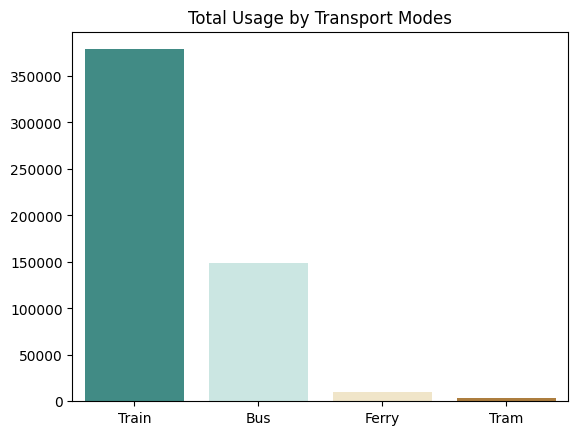

In [8]:
# Retrieve data for all transport modes and create plot
trans_modes_total = age_total.drop(["Total"], axis=1)
sns.barplot(data= trans_modes_total, palette= "BrBG_r").set_title("Total Usage by Transport Modes")

* ***Interpretation:*** Train service stands out as the transport mode with the highest passengers across all age groups (378778 taps in total).

And another plot to find out how each age group _uses all the transport modes_:

In [9]:
# Retrive data for all transport modes by age groups
trans_modes_by_agegr = df_age.drop(["Class", "Total"], axis=1)
trans_modes_by_agegr["Age Groups"] = trans_modes_by_agegr.index
trans_modes_by_agegr

,Train,Bus,Ferry,Tram,Age Groups
AGE10P - Age in Ten Year Groups,,,,,
10-19 years,10869,8421,69,74,10-19 years
20-29 years,115402,41592,1702,914,20-29 years
30-39 years,114937,40941,3094,1077,30-39 years
40-49 years,69864,28815,2617,722,40-49 years
50-59 years,48007,19717,1522,452,50-59 years
60-69 years,17732,7824,543,159,60-69 years
70-79 years,1781,973,88,13,70-79 years
80-89 years,166,92,4,0,80-89 years
90-99 years,20,13,0,0,90-99 years


In [10]:
# Unpivot the data by transport types
trans_modes_by_agegr_melted = pd.melt(trans_modes_by_agegr, id_vars = "Age Groups", var_name="Transport Types")
trans_modes_by_agegr_melted.head(9)

,Age Groups,Transport Types,value
0,10-19 years,Train,10869
1,20-29 years,Train,115402
2,30-39 years,Train,114937
3,40-49 years,Train,69864
4,50-59 years,Train,48007
5,60-69 years,Train,17732
6,70-79 years,Train,1781
7,80-89 years,Train,166
8,90-99 years,Train,20


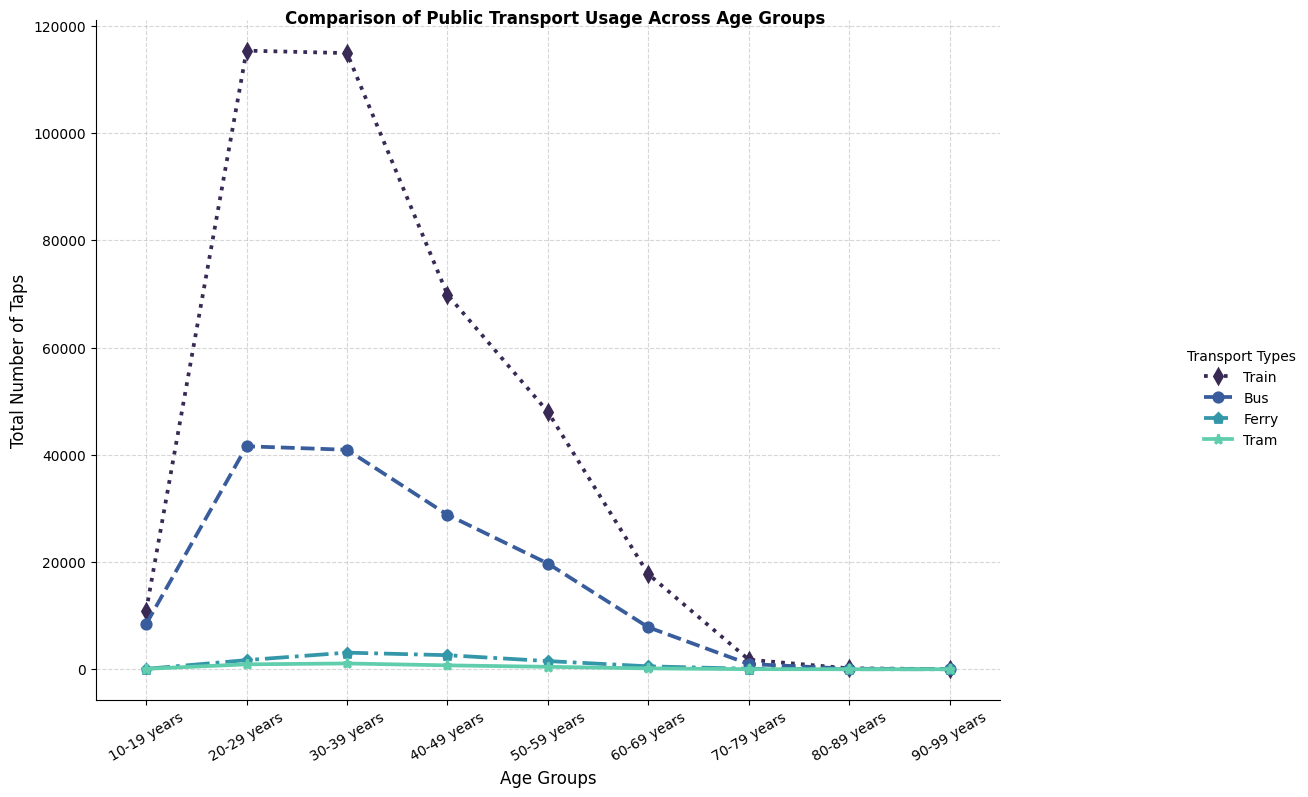

In [11]:
# Create the plot
trans_modes_by_agegr_plot = sns.catplot(
    x="Age Groups", y="value",
    markers=["d", "o", "p", "*"], 
    linestyles=["dotted", "dashed", "dashdot", "solid"],
    kind="point", hue="Transport Types",
    data=trans_modes_by_agegr_melted, palette="mako"
)

# Adjust figure size
trans_modes_by_agegr_plot.fig.set_size_inches(15,8)

# Set title with better font size
trans_modes_by_agegr_plot.fig.suptitle(
    "Comparison of Public Transport Usage Across Age Groups", 
    fontsize=12, fontweight="bold"
)

# Set axis labels
plt.xlabel("Age Groups", fontsize=12)
plt.ylabel("Total Number of Taps", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=30)

# Adjust legend position for better visibility
# plt.legend(title="Transport Types", loc="upper right", fontsize=10)

# Add gridlines for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

**Key Insights:** 
   1. **Train and Bus are the most used transport modes**, peaking in the **20-29 age group** and declining sharply after 50 years.
   2. **Ferry and Tram usage remain low** across all age groups, suggesting _limited accessibility or demand_.
   3. **Public transport usage drops significantly after 50 years**, likely due to _alternative transport options or reduced mobility_.
   4. **Young adults (20s-30s) rely most on public transport**, possibly for commuting, while older groups use it less.

Analyzing the usage of each transport mode by each age range in percentage will provide a proper assessment on **how all transport modes are distributed**.

In [12]:
# Transform the data to percentage
transport_modes = ["Train", "Bus", "Ferry", "Tram"]
df_age[transport_modes] = df_age[transport_modes].div(df_age["Total"], axis=0) * 100
df_age.fillna(0, inplace=True)  # Replace NaN values if any division by zero occurred
# View the updated dataframe
df_age

,Train,Bus,Ferry,Tram,Total,Class
AGE10P - Age in Ten Year Groups,,,,,,
10-19 years,55.930633,43.333505,0.355066,0.380796,19433,0
20-29 years,72.302487,26.058518,1.066349,0.572646,159610,0
30-39 years,71.813632,25.580291,1.933158,0.672919,160049,0
40-49 years,68.482033,28.245016,2.565234,0.707718,102018,0
50-59 years,68.87859,28.289191,2.183707,0.648512,69698,0
60-69 years,67.529896,29.796633,2.067941,0.60553,26258,1
70-79 years,62.381786,34.08056,3.082312,0.455342,2855,1
80-89 years,63.358779,35.114504,1.526718,0.0,262,1
90-99 years,60.606061,39.393939,0.0,0.0,33,1


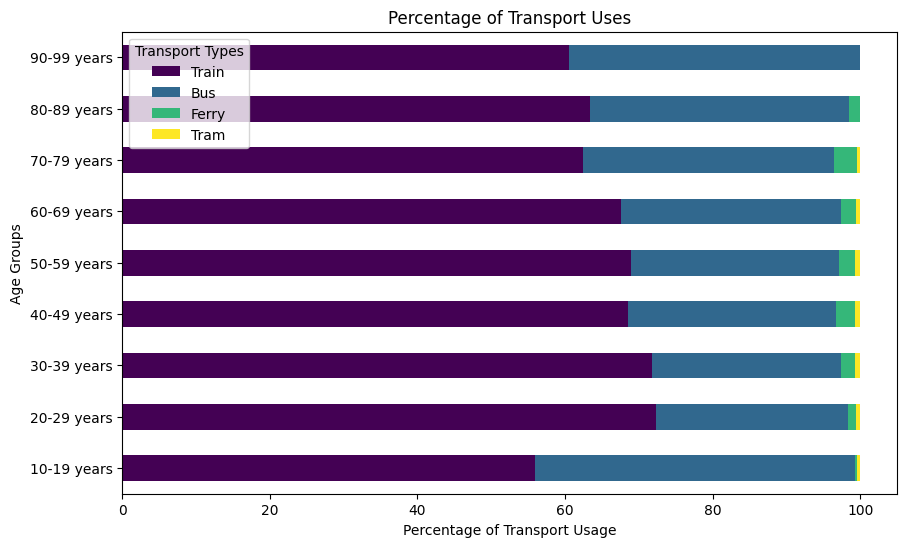

In [13]:
# Plot how all transport modes are distributed in each age range
trans_modes_by_agegr_perc = df_age[["Train", "Bus", "Ferry", "Tram"]].copy()
trans_modes_by_agegr_perc["Age Groups"] = df_age.index

trans_modes_by_agegr_perc_plot = trans_modes_by_agegr_perc.plot(
    x="Age Groups", kind="barh", stacked=True, 
    title="Percentage of Transport Uses", colormap="viridis", figsize=(10, 6)
)
trans_modes_by_agegr_perc_plot.set_xlabel("Percentage of Transport Usage")
trans_modes_by_agegr_perc_plot.set_ylabel("Age Groups")
trans_modes_by_agegr_perc_plot.legend(title="Transport Types")

**Key Insights:**
1. **Train is dominant for young adults (20-39 years) (_~70%_)**, but usage declines with age.
2. **Bus usage increases with age**, becoming the primary mode for seniors (60+ years).
3. **Ferry & Tram have minimal usage**, slightly higher in older groups.

Lastly, we examine how **the number of travellings of each age class varies**. (Note: _we have defined two classes_).

<Axes: xlabel='Class', ylabel='Total'>

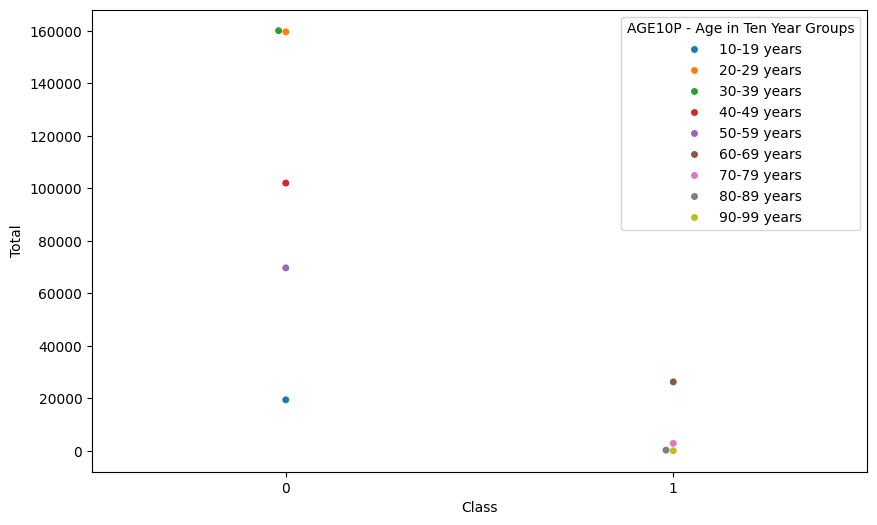

In [14]:
# Plot transport usage by each age class
plt.figure(figsize=(10,6))
sns.swarmplot(x='Class', y='Total', data= df_age, hue= df_age.index)

**Key Insights:** 
- **Class 0 (Younger & Middle-aged adults)**: Ages **10-59 years**, showing significantly higher transport usage. The peak is in the **20-39 age range**, suggesting _working-age individuals rely heavily on public transport_.
- **Class 1 (Older adults & Seniors)**: Ages **60-99 years**, with a sharp decline in transport usage. The lowest values are in the **80+ age groups**, reflecting _reduced mobility or alternative transport choices_.

## Model Training 

**Overview**: 

We use all `travelling statistics` as _independent variables_ to predict `class` as the _target variable_.

`Logistic Regression`, `K-Nearest Neighbours Classifier`, `Gaussian Naive Bayes`, `Multi-layer Perception` will be applied and assessed to retrieve the most optimal model.

### Splitting Data

In [20]:
# Split data into training and testing sets (50% each)
train, test = train_test_split(df_age, test_size=0.5, random_state=7)

# Separate features and target
X_train, X_test = train.drop(columns=['Total', 'Class']), test.drop(columns=['Total', 'Class'])
y_train, y_test = train['Class'], test['Class']

# Print shapes for verification
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Train shape: (4, 6), Test shape: (5, 6)
X_train: (4, 4), y_train: (4,)
X_test: (5, 4), y_test: (5,)


In [24]:
X_train

,Train,Bus,Ferry,Tram
AGE10P - Age in Ten Year Groups,,,,
40-49 years,68.482033,28.245016,2.565234,0.707718
70-79 years,62.381786,34.08056,3.082312,0.455342
20-29 years,72.302487,26.058518,1.066349,0.572646
50-59 years,68.87859,28.289191,2.183707,0.648512


In [25]:
X_test

,Train,Bus,Ferry,Tram
AGE10P - Age in Ten Year Groups,,,,
30-39 years,71.813632,25.580291,1.933158,0.672919
80-89 years,63.358779,35.114504,1.526718,0.0
10-19 years,55.930633,43.333505,0.355066,0.380796
90-99 years,60.606061,39.393939,0.0,0.0
60-69 years,67.529896,29.796633,2.067941,0.60553


### Logistic Regression

**Fitting the model:**

In [21]:
# Create model instance and fit the training data 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [22]:
# Produce predictions with LR model 
y_train_pred = lr.predict(X_train)
y_test_pred= lr.predict(X_test)

In [26]:
# Evaluate LR model
print(f"Accuracy Score on training test: {accuracy_score(y_train,y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test,y_test_pred)}")

Accuracy Score on training test: 1.0
Accuracy Score on testing test: 0.6


The model has a **perfect accuracy (1.0)** _on the training set_ but a **lower accuracy (0.6)** _on the testing set_, which suggests **overfitting**.

In [32]:
# define the model evaluation procedure
lr_cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=7)

In [33]:
# list of accuracy score of test set
test_scores = []
test_scores.append(accuracy_score(y_test,y_test_pred))

* ***Comment:*** The accuracy scoreis 0.8 which is significantly high and suggests that the model was constructed well. However, it is possible that this model is overfitting due to the training accuracy score is 1.0 as a result of small dataset.

In [ ]:
# Checking confusion metric 
print ("Confusion matrix on test set:")
print(confusion_matrix(y_test,y_pred_test))

Confusion matrix on test set:
[[1 1]
 [0 3]]


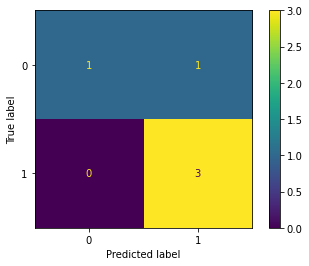

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

* ***Comment:*** The confusion matrix indicates 0 false negatives and 1 false positives, this resulting rate is acceptable and supports the significance of the model.

In [ ]:
acc_scores = []
for i in range(1,5):
    clf = LogisticRegression(max_iter=1000)
    rfe = RFE(estimator =clf, n_features_to_select=i)
    #training model
    rfe.fit(X_train, y_train)
    #predicting on test set 
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print ("Acc on test set using", i, "feature: ", acc_score)
    print ("Feature which have been chosen:", X_train.columns[rfe.support_])
    print("")
    # append to the list 
    acc_scores.append(acc_score)

Acc on test set using 1 feature:  0.8
Feature which have been chosen: Index(['Bus'], dtype='object')

Acc on test set using 2 feature:  0.8
Feature which have been chosen: Index(['Train', 'Bus'], dtype='object')

Acc on test set using 3 feature:  0.8
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry'], dtype='object')

Acc on test set using 4 feature:  0.8
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry', 'Tram'], dtype='object')



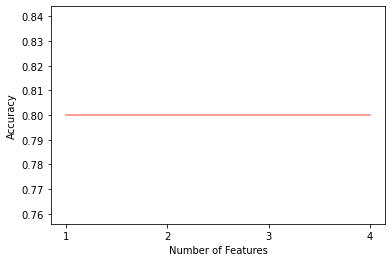

In [ ]:
# Plotting the accuracy number
plotting = plt.plot(range(1, X_train.shape[1]+1), acc_scores, color= "salmon")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, 5 , step=1))
plt.show()

* ***Comment:*** RFE suggests that the accuracy remains the same for the selection of features. Therefore, we choose all four features to conduct a model and prevent the overfitting problem.

Cross Validation Testing

In [ ]:
X= df_age.drop(["Total", "Class"], axis= 1)
y= df_age["Class"]

In [ ]:
lr = LogisticRegression(max_iter=1000)
scores = cross_val_score(lr, X, y, scoring='accuracy', cv=3)
print('Accuracy range for Logistic Regression: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Logistic Regression: [0.6667, 1.0000]; mean: 0.7778; std: 0.1571



### K-Nearest Neighbours Classifier

Train and Test sets Splitting

In [ ]:
# choosing the nearest 3 neighbours
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# do prediction
train_pred = clf_knn.predict(X_train)
test_pred = clf_knn.predict(X_test)

In [ ]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 0.75
Accuracy of the test set: 0.4


* ***Comment:*** Both accuracy scores of the train and test set is considerably lower than the result of Logistic Regression.

Cross Validation Testing

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=2)
print('Accuracy range for K-Nearest Neighbours: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for K-Nearest Neighbours: [0.7500, 0.8000]; mean: 0.7750; std: 0.0250



### Gaussian Naive Bayes

Train and Test set splitting

In [ ]:
# train the model
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
# do prediction
train_pred = clf_gnb.predict(X_train)
test_pred = clf_gnb.predict(X_test)

In [ ]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 1.0
Accuracy of the test set: 0.4


* ***Comment:*** The accuracy of the test set is the lowest of all three models that we have conducted so far while the accuracy of the train set reaches 1.0 which can indicate the a overfitting model.

Cross Validation Testing

In [ ]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, scoring='accuracy', cv=5)
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Gaussian Naive Bayes: [0.5000, 1.0000]; mean: 0.9000; std: 0.2000



* ***Comment:*** The mean accuracy score of the Gaussian Naive Bayes is significantly high with 0.9 after using the cross validation testing.

### Multi-layer Perceptron

Train and Test Sets Splitting

In [ ]:
# train the model
clf_nn = MLPClassifier(max_iter=800,solver="lbfgs",activation="tanh",random_state=42)
clf_nn.fit(X_train, y_train)

MLPClassifier(activation='tanh', max_iter=800, random_state=42, solver='lbfgs')

In [ ]:
# do prediction
train_pred = clf_nn.predict(X_train)
test_pred = clf_nn.predict(X_test)

In [ ]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 1.0
Accuracy of the test set: 0.6


* ***Comment:*** The result is roughly the same as that of Gaussian Naives Bayes which also shows the possible overfitting problem.

Cross Validation Testing 

In [ ]:
nn =  MLPClassifier(max_iter=800, solver="lbfgs",activation="tanh",random_state=42)
scores = cross_val_score(nn, X, y, scoring='accuracy', cv=4)
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Gaussian Naive Bayes: [0.6667, 1.0000]; mean: 0.9167; std: 0.1443



* ***Comment:*** The mean accuracy score is as high as the result of the Gaussian Naives Bayes model using cross validation test.

### Choosing the Best Model

In [ ]:
# dataframe of accuracy scores
models = ["LR_Split", "LR_CV", "KNN_Split", "KNN_CV", "GNB_Split",
         "GNB_CV", "MLP_Split", "MLP_CV"]
df_acc = pd.DataFrame(models, columns=["Model Type"])
df_acc["Accuracy"] = test_scores

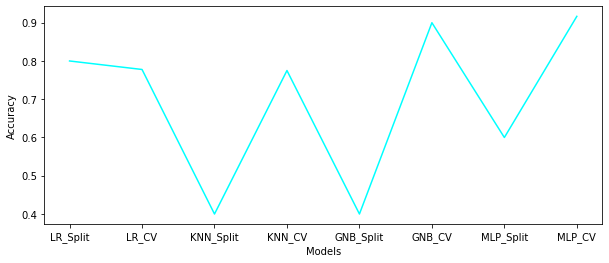

In [ ]:
# Plotting the accuracy number
plt.figure (figsize = (10,4))
plt.plot(df_acc["Model Type"], df_acc["Accuracy"], color= "aqua")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

* ***Interpretation:*** Of all the models that we have conducted so far, it appears that the Logistics Regression model comes up with the most stable result with 0.8 and 0.78 for the train test splitting and cross validation testing respectively. In contrast, for the rest three models, the differences of the model results when conducting in two ways are considerably high which will refect the prediction well enough. Therefore, the Logistics Regression model should be applied to predict the age groups based on the transport uses.

## Conclusion

The age group dataset used in this section have to be modified carefully. Firstly we remove logo and title which we did the same for the second dataset. Then, we have to remove outliers since there are two groups with zero-records. Also, we have to recalculate the total field to minimise the incorrect data. The most noticeable feature in this dataset is that the size of the dataset is small, thus it may lead to the overfitting model.

We repeated the same data exploration steps as in the second dataset to discover the relationship between each age group and the uses of each transport service modes.

Since there are significant differences in the results of GNB, KNN and MLPClassifier models which might be due to the dataset size (affect on the constant train and test set using the split method), it is reasonable to not choose them as the best predicted result to avoid the overfitting and incorrect prediction. On the other hand, we will choose the Logistic Regression model which has the stable accuracy scores through two testing methods (train-test split and cross validation) to be the best learning result in this case (although it might not be very good model since the limited dataset size).